<a href="https://colab.research.google.com/github/dstekanov/ai-math-with-code/blob/main/quora_question_pairs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Крок 0: Підготовка Google Colab

In [9]:
# ⬇️ Завантаження бібліотек
import pandas as pd
import re
import string

In [10]:
# 📥 Завантаження файлу (якщо вручну з Colab)
# from google.colab import files

# uploaded = files.upload()

In [13]:
# 📄 Читання CSV (файл має бути 'train.csv')
df = pd.read_csv('train.csv')
# df = pd.read_csv('train.csv')

df = df.head(10_000)

# Виводимо перші 5 рядків
df[['question1', 'question2', 'is_duplicate']].head()

,question1,question2,is_duplicate
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


# Крок 1: Базовий препроцесінг

In [14]:
# 🧼 Базова очистка — видаляємо пропущені значення
df = df.dropna(subset=["question1", "question2"])

In [15]:
# 🔤 Функція препроцесінгу
def basic_preprocess(text):
    text = text.lower()
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

In [16]:
# 🧽 Застосування до обох питань
df["q1_clean"] = df["question1"].apply(basic_preprocess)
df["q2_clean"] = df["question2"].apply(basic_preprocess)

In [17]:
# 👀 Перевірка результатів
df[["question1", "q1_clean", "question2", "q2_clean"]].head()

,question1,q1_clean,question2,q2_clean
0,What is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,what is the story of kohinoor kohinoor diamond,What would happen if the Indian government sto...,what would happen if the indian government sto...
2,How can I increase the speed of my internet co...,how can i increase the speed of my internet co...,How can Internet speed be increased by hacking...,how can internet speed be increased by hacking...
3,Why am I mentally very lonely? How can I solve...,why am i mentally very lonely how can i solve it,Find the remainder when [math]23^{24}[/math] i...,find the remainder when math2324math is divide...
4,"Which one dissolve in water quikly sugar, salt...",which one dissolve in water quikly sugar salt ...,Which fish would survive in salt water?,which fish would survive in salt water


# 🔹 Крок 2: TF-IDF Vectorization + Cosine Similarity

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Об'єднуємо всі тексти
all_qs = pd.concat([df['q1_clean'], df['q2_clean']], axis=0)

# Векторизатор
tfidf = TfidfVectorizer(max_features=5000)
tfidf_matrix = tfidf.fit_transform(all_qs)

# Розділяємо знову на question1 і question2
q1_tfidf = tfidf_matrix[:len(df)]
q2_tfidf = tfidf_matrix[len(df):]

# Косинусна схожість
df['tfidf_cosine'] = [cosine_similarity(q1, q2)[0][0] for q1, q2 in zip(q1_tfidf, q2_tfidf)]

# Виводимо приклади
df[['question1', 'question2', 'tfidf_cosine']].head(5)


,question1,question2,tfidf_cosine
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0.978922
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0.802600
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0.305513
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0.000000
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0.391360


📌 Cosine similarity показує, наскільки тексти “схожі” у векторному просторі.

# 🔹 Крок 3: Sentence-BERT embedding + Cosine Similarity

In [19]:
from sentence_transformers import SentenceTransformer
import numpy as np

model = SentenceTransformer('all-MiniLM-L6-v2')

# Ембедінги
q1_embeds = model.encode(df['q1_clean'].tolist(), batch_size=64, show_progress_bar=True)
q2_embeds = model.encode(df['q2_clean'].tolist(), batch_size=64, show_progress_bar=True)

np.save("q1_embeds.npy", q1_embeds)
np.save("q2_embeds.npy", q2_embeds)

# Косинусна схожість
sbert_cosine = [cosine_similarity([a], [b])[0][0] for a, b in zip(q1_embeds, q2_embeds)]
df['sbert_cosine'] = sbert_cosine

# Виводимо 5 перших рядків
df[['question1', 'question2', 'sbert_cosine']].head()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Batches:   0%|          | 0/157 [00:00<?, ?it/s]

,question1,question2,sbert_cosine
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0.891514
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0.712437
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0.499448
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0.159214
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0.212026


📌 SBERT розуміє сенс, а не лише слова. Навіть перефразовані речення можуть мати високу схожість.

# 🔹 Крок 4: Просте Feature Engineering

In [20]:
# ✅ Довжина запитань (Length features)
# - довжин question1 і question2 (кількість символів або слів)
# - різницю довжин
# - відношення довжин

df['q1_len'] = df['question1'].apply(lambda x: len(x.split()))
df['q2_len'] = df['question2'].apply(lambda x: len(x.split()))
df['len_diff'] = abs(df['q1_len'] - df['q2_len'])

print(df['len_diff'].describe())

count    10000.00000
mean         3.72770
std          5.03586
min          0.00000
25%          1.00000
50%          2.00000
75%          5.00000
max        200.00000
Name: len_diff, dtype: float64


In [21]:
def jaccard_similarity(q1, q2):
    w1 = set(q1.split())
    w2 = set(q2.split())
    if len(w1.union(w2)) == 0:
        return 0
    return len(w1.intersection(w2)) / len(w1.union(w2))

df['jaccard'] = df.apply(lambda row: jaccard_similarity(row['q1_clean'], row['q2_clean']), axis=1)

print(df['jaccard'].describe())

count    10000.000000
mean         0.362733
std          0.240259
min          0.000000
25%          0.174728
50%          0.315789
75%          0.504310
max          1.000000
Name: jaccard, dtype: float64


In [22]:
df[['question1', 'question2', 'len_diff', 'jaccard', 'sbert_cosine']].head()

,question1,question2,len_diff,jaccard,sbert_cosine
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,2,0.916667,0.891514
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,5,0.285714,0.712437
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,4,0.200000,0.499448
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,2,0.000000,0.159214
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,6,0.250000,0.212026


# 🔹 Крок 5: Візуалізація для розуміння

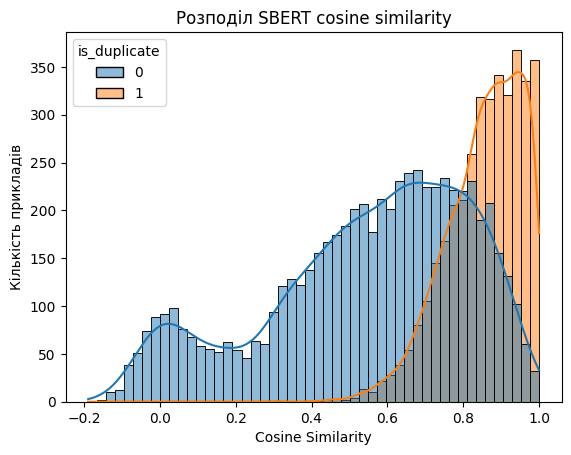

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Приклад: розподіл sbert_cosine для дублікатів і не-дублікатів
sns.histplot(data=df, x='sbert_cosine', hue='is_duplicate', bins=50, kde=True)
plt.title("Розподіл SBERT cosine similarity")
plt.xlabel("Cosine Similarity")
plt.ylabel("Кількість прикладів")
plt.show()

Чи можна знайти пари з cosine similarity = 1?

In [24]:
# Знаходимо всі пари, де cosine similarity максимально близьке до 1
max_val = df['sbert_cosine'].max()
matches = df[df['sbert_cosine'] >= 0.9999][['question1', 'question2', 'sbert_cosine']]
print(matches.head(3).to_string())
print(max_val)

                                                                       question1                                                                    question2  sbert_cosine
1024                          What do you think about the movie, "Interstellar"?                              What do you think about the movie Interstellar?           1.0
1209  What are the minimum GPA and GRE requirements of Florida State University?  What are the minimum GPA and  GRE requirements of Florida State University?           1.0
1259               What is the difference between "assessment" and "evaluation"?                    What is the difference between assessment and evaluation?           1.0
1.000000238418579


## 🔹 Baseline модель (логістична регресія)

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Вибираємо фічі
features = ['sbert_cosine', 'len_diff', 'jaccard']
X = df[features]
y = df['is_duplicate']

# Тренувальна та тестова вибірка
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Логістична регресія
model = LogisticRegression()
model.fit(X_train, y_train)

# Прогноз
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.787


# 🔹 Візуалізація AUC та точності

AUC: 0.8722322731687346


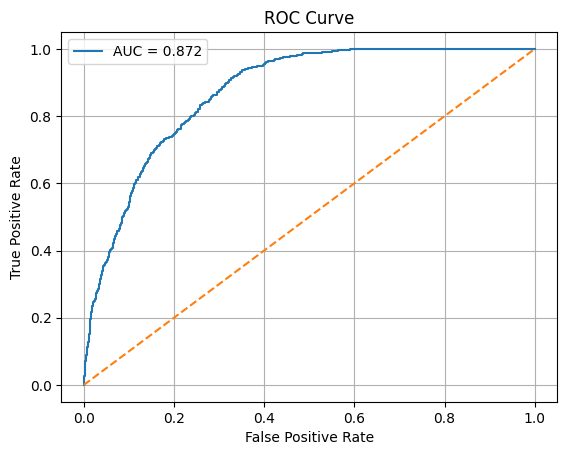

In [26]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Ймовірність замість 0/1
y_probs = model.predict_proba(X_test)[:, 1]

# AUC
auc = roc_auc_score(y_test, y_probs)
print("AUC:", auc)

# Побудова ROC кривої
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], '--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# ✅ Крок 0: Імпорт бібліотек

In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

✅ Крок 1: Підготовка даних

In [28]:
# Припустимо, у вас вже є DataFrame df з такими колонками:
# ['sbert_cosine', 'jaccard', 'len_diff', 'is_duplicate']

# Розділяємо X та y
features = ['sbert_cosine', 'jaccard', 'len_diff']
X = df[features]
y = df['is_duplicate']

# ✅ Крок 2: Тренувальний і тестовий спліт + пайплайн

In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Побудова пайплайна з логістичною регресією
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(solver='liblinear'))
])

# ✅ Крок 3: Крос-валідація

In [30]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accuracy = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='accuracy')
f1 = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='f1')
auc = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='roc_auc')

print(f"Accuracy (CV): {accuracy.mean():.4f}")
print(f"F1 Score (CV): {f1.mean():.4f}")
print(f"AUC (CV): {auc.mean():.4f}")


Accuracy (CV): 0.7961
F1 Score (CV): 0.7314
AUC (CV): 0.8784


# ✅ Крок 4: Навчання моделі + оцінка на тесті

In [31]:
pipeline.fit(X_train, y_train)
y_proba = pipeline.predict_proba(X_test)[:, 1]
y_pred = pipeline.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
print(f"AUC: {roc_auc_score(y_test, y_proba):.4f}")

Accuracy: 0.7850
F1 Score: 0.7229
AUC: 0.8752


# ✅ Крок 5: Підбір порогу

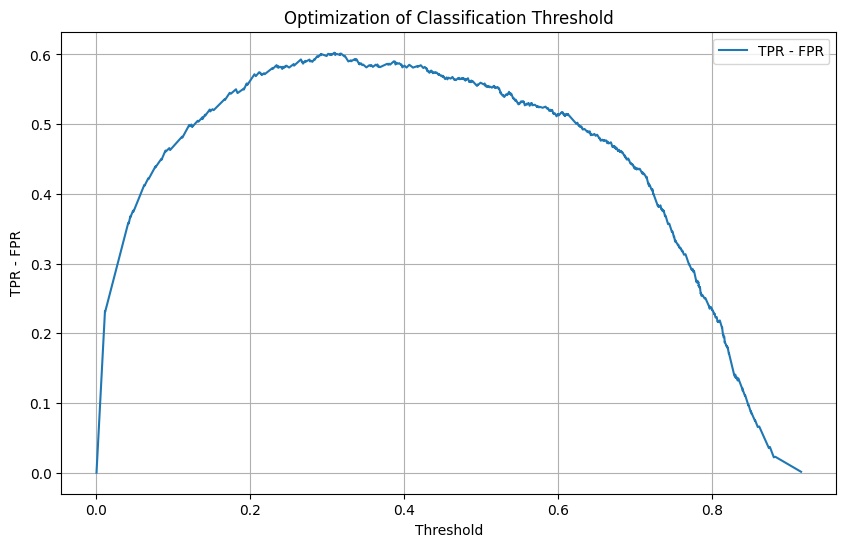

Optimal threshold: 0.31
F1 (optimal): 0.7486
Accuracy (optimal): 0.7750


In [32]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(10, 6))
plt.plot(thresholds, tpr - fpr, label="TPR - FPR")
plt.xlabel("Threshold")
plt.ylabel("TPR - FPR")
plt.title("Optimization of Classification Threshold")
plt.grid(True)
plt.legend()
plt.show()

# Знайдемо найкращий поріг
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal threshold: {optimal_threshold:.2f}")

# Використаємо його
y_pred_opt = (y_proba >= optimal_threshold).astype(int)
print(f"F1 (optimal): {f1_score(y_test, y_pred_opt):.4f}")
print(f"Accuracy (optimal): {accuracy_score(y_test, y_pred_opt):.4f}")


# ✅ Крок 6: Важливість фіч

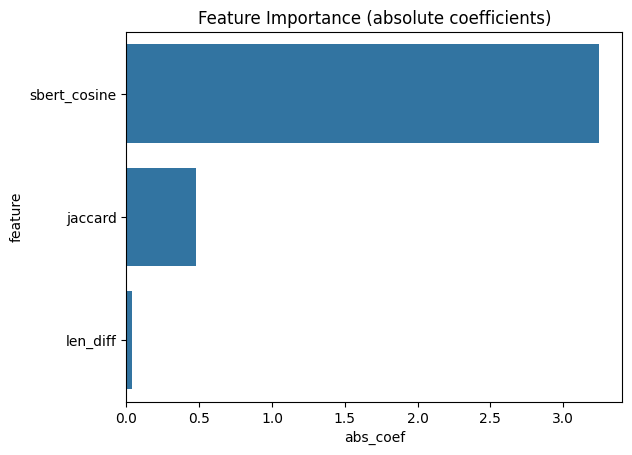

In [33]:
# Витягаємо ваги моделі
model = pipeline.named_steps['clf']
coefficients = model.coef_[0]
importance_df = pd.DataFrame({
    'feature': features,
    'coefficient': coefficients,
    'abs_coef': np.abs(coefficients)
}).sort_values(by='abs_coef', ascending=False)

sns.barplot(data=importance_df, x='abs_coef', y='feature')
plt.title('Feature Importance (absolute coefficients)')
plt.show()


# ✅ Частина 1: XGBoost

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [09:07:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Optimal threshold: 0.37
F1 (optimal): 0.7430
Accuracy (optimal): 0.7800
AUC: 0.8659


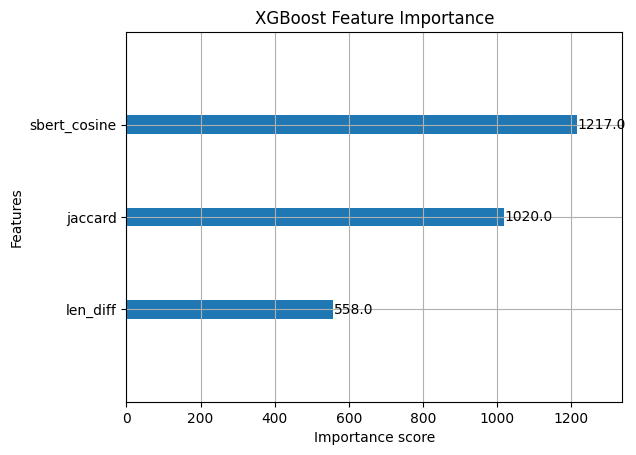

In [34]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# === Дані
X = df[['sbert_cosine', 'jaccard', 'len_diff']]
y = df['is_duplicate']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# === Модель
model_xgb = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

model_xgb.fit(X_train, y_train)
y_proba = model_xgb.predict_proba(X_test)[:, 1]

# === Оптимальний поріг
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal threshold: {optimal_threshold:.2f}")

y_pred_opt = (y_proba >= optimal_threshold).astype(int)
print(f"F1 (optimal): {f1_score(y_test, y_pred_opt):.4f}")
print(f"Accuracy (optimal): {accuracy_score(y_test, y_pred_opt):.4f}")
print(f"AUC: {roc_auc_score(y_test, y_proba):.4f}")

# === Важливість фіч
xgb.plot_importance(model_xgb)
plt.title('XGBoost Feature Importance')
plt.show()


✅ Як поміряти LogLoss

In [35]:
from sklearn.metrics import log_loss

# Передбачення ймовірностей
y_proba = model_xgb.predict_proba(X_test)[:, 1]

# Обчислення log loss
ll = log_loss(y_test, y_proba)
print(f"LogLoss: {ll:.5f}")


LogLoss: 0.43746


# ✅ Частина 2: Глибока нейронна мережа (Keras)

In [36]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler

# === Скейлінг
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === Модель
model_dnn = Sequential([
    Dense(16, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.2),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_dnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# === Навчання
history = model_dnn.fit(X_train_scaled, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=0)

# === Оцінка
y_proba_dnn = model_dnn.predict(X_test_scaled).flatten()
fpr_dnn, tpr_dnn, thresholds_dnn = roc_curve(y_test, y_proba_dnn)
optimal_idx_dnn = np.argmax(tpr_dnn - fpr_dnn)
optimal_threshold_dnn = thresholds_dnn[optimal_idx_dnn]

y_pred_opt_dnn = (y_proba_dnn >= optimal_threshold_dnn).astype(int)
print(f"Optimal threshold: {optimal_threshold_dnn:.2f}")
print(f"F1 (optimal): {f1_score(y_test, y_pred_opt_dnn):.4f}")
print(f"Accuracy (optimal): {accuracy_score(y_test, y_pred_opt_dnn):.4f}")
print(f"AUC: {roc_auc_score(y_test, y_proba_dnn):.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
Optimal threshold: 0.28
F1 (optimal): 0.7574
Accuracy (optimal): 0.7825
AUC: 0.8834


✅ Як поміряти LogLoss

In [37]:
y_proba_dnn = model_dnn.predict(X_test_scaled).flatten()
ll_dnn = log_loss(y_test, y_proba_dnn)
print(f"LogLoss (DNN): {ll_dnn:.5f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
LogLoss (DNN): 0.40492
